### How to load the data

This jupyter notebook demonstrates how to access the data of the dataset. To run the notebook you will need to install the following packages:
- pymef (to read MEF3 format)
- pybids (to load the BIDS data structure)


Let's do the imports first

In [113]:
import os

from pymef import MefSession
from bids import BIDSLayout

import numpy as np
import matplotlib.pyplot as plt


Now load the BIDS dataset

In [114]:
path_to_dataset = r"C:\MasterThesis\v1.0"  # Please change this value

l = BIDSLayout(path_to_dataset)

Define what data we want to load

In [115]:
filter_dictionary = {'subject': '004',
                     'session': '001',
                     'task': 'FR',
                     'run': 1,
                     'suffix': 'ieeg',
                     'extension': 'json'}
json_files = l.get(**filter_dictionary)

# We now we have requested only one file now but multiple files can be processed in a for loop
json_file = json_files[0]
print(json_file)

json_entities = json_file.entities

<BIDSJSONFile filename='C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.json'>


Load the information about electrodes

In [116]:
# Get electrodes
electrodes_file = l.get(suffix='electrodes', extension='tsv',
                        subject=json_entities['subject'],
                        session=json_entities['session'])[0]
electrode_df = electrodes_file.get_df()
electrode_df

,name,x,y,z,size,material,manufacturer,group,type,anatomy_structure
0,LZ_01,4.2,15.6,68.1,2,Pt,PMT,LZ,ring,wm
1,LZ_10,-26.6,17.0,85.0,2,Pt,PMT,LZ,ring,precentral gyrus
2,LAM_08,-31.5,-46.3,66.8,2,Pt,PMT,LAM,ring,middle temporal gyrus
3,LAM_09,-34.4,-48.0,68.8,2,Pt,PMT,LAM,ring,middle temporal gyrus
4,LAM_10,-37.2,-49.7,70.8,2,Pt,PMT,LAM,ring,middle temporal gyrus
...,...,...,...,...,...,...,...,...,...,...
123,LAM_03,-17.3,-38.0,56.6,2,Pt,PMT,LAM,ring,wm
124,LAM_04,-20.1,-39.6,58.7,2,Pt,PMT,LAM,ring,middle temporal gyrus
125,LAM_05,-23.0,-41.3,60.7,2,Pt,PMT,LAM,ring,middle temporal gyrus
126,LAM_06,-25.8,-43.0,62.7,2,Pt,PMT,LAM,ring,middle temporal gyrus


Load information about channels

In [117]:
# Get channels
channel_file = l.get(suffix='channels', extension='tsv',
                     task=json_entities['task'],
                     subject=json_entities['subject'],
                     session=json_entities['session'],
                     run=json_entities['run'])[0]
channel_df = channel_file.get_df()
channel_df = channel_df[channel_df['status'] != 'bad']
channel_df
    

,name,type,units,low_cutoff,high_cutoff,reference,sampling_frequency,status,status_description
0,LAM_01,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
2,LAM_03,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
3,LAM_04,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
4,LAM_05,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
5,LAM_06,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
...,...,...,...,...,...,...,...,...,...
132,RIGHT_PUPIL_SIZE,PUPIL,px2,NaN,NaN,scalp_cpz,150,good,NaN
133,RIGHT_X_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
134,RIGHT_Y_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
135,SCREEN_X,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN


Load events

In [118]:
events_file = l.get(suffix='events', extension='tsv',
                    task=json_entities['task'],
                    subject=json_entities['subject'],
                    session=json_entities['session'],
                    run=json_entities['run'])[0]
events_df = events_file.get_df()

# Pull only the processed events (discarding the original events)
events_df = events_df.loc[~events_df['trial_type'].isna(), ['onset', 'sample', 'duration', 'trial_type', 'list']]
events_df = events_df[events_df['trial_type'] == 'ENCODE']
events_df = events_df.reset_index(drop=True)
events_df


,onset,sample,duration,trial_type,list
0,375.780287,12024969,1.494031,ENCODE,1.0
1,378.278411,12104909,1.495906,ENCODE,1.0
2,380.786316,12185162,1.488000,ENCODE,1.0
3,383.279534,12264945,1.494781,ENCODE,1.0
4,385.780283,12344969,1.494031,ENCODE,1.0
...,...,...,...,...,...
175,1924.491728,61583735,1.495061,ENCODE,15.0
176,1926.991914,61663741,1.494906,ENCODE,15.0
177,1929.494851,61743835,1.491968,ENCODE,15.0
178,1931.994350,61823819,1.492468,ENCODE,15.0


Now load the raw data

In [119]:
# Since we are using MEF3 pybids has problems recognizing the extension so we need to modify the json extension
mef_session_path = os.path.splitext(json_file.path)[0]+'.mefd'
print(mef_session_path)
ms = MefSession(mef_session_path, None)
ms.read_ts_channel_basic_info()

C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.mefd


[{'name': 'LAM_01',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_02',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_03',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')}

Now load the data as they are presented in the manuscript Figure 3

In [139]:
channels = ['LEFT_PUPIL_SIZE', 'RIGHT_PUPIL_SIZE',  # Eye tracking
            # 'MIC',  # Audio
            # 'LK_02', 'LAM_03', 'LAM_04'  # iEEG
           ]

# Microseconds 1 μs = 10⁻⁶ s
start_time = 1553941347170839+3*1e6  # in microseconds
win_size = 1000  # in seconds
stop_time = start_time + int(win_size*1e6)

data = ms.read_ts_channels_uutc(channels, [start_time, stop_time])
bi = ms.read_ts_channel_basic_info()

# In this case we are reading MEF records instead of data from events.tsv because we do not have to make time conversions this way
records = ms.read_records()
records_in_win = [x for x in records if start_time < x['time'] < stop_time]

# The code to get corresponding events from the events file
session_metadata = ms.session_md
session_start_utc = session_metadata['session_specific_metadata']['earliest_start_time'][0]
print(f"session_start_utc = {session_start_utc}\nsession_stop_utc = {stop_time}")
events_df['microsecond_onset'] = events_df['onset']*1e6
events_df['uutc'] = (events_df['microsecond_onset'] + session_start_utc).astype('int64')
events_in_win = events_df[(start_time < events_df['uutc'])
                          & (events_df['uutc'] < stop_time)]
events_in_win

[{'type': 'SyLg', 'time': 1553940962253768, 'text': 'trialstart_1'}, {'type': 'SyLg', 'time': 1553940967251359, 'text': 'orient'}, {'type': 'SyLg', 'time': 1553940969248984, 'text': 'blankScreen'}, {'type': 'SyLg', 'time': 1553940970258139, 'text': 'wordstart_1'}, {'type': 'SyLg', 'time': 1553940971748983, 'text': 'wordEnd'}, {'type': 'SyLg', 'time': 1553940972752951, 'text': 'wordstart_2'}, {'type': 'SyLg', 'time': 1553940974248982, 'text': 'wordEnd'}, {'type': 'SyLg', 'time': 1553940975253606, 'text': 'wordstart_3'}, {'type': 'SyLg', 'time': 1553940976749012, 'text': 'wordEnd'}, {'type': 'SyLg', 'time': 1553940977752918, 'text': 'wordstart_4'}, {'type': 'SyLg', 'time': 1553940979248980, 'text': 'wordEnd'}, {'type': 'SyLg', 'time': 1553940980253042, 'text': 'wordstart_5'}, {'type': 'SyLg', 'time': 1553940981749010, 'text': 'wordEnd'}, {'type': 'SyLg', 'time': 1553940982753009, 'text': 'wordstart_6'}, {'type': 'SyLg', 'time': 1553940984248978, 'text': 'wordEnd'}, {'type': 'SyLg', 'time

,onset,sample,duration,trial_type,list,microsecond_onset,uutc
12,472.127998,15108095,1.494500,ENCODE,2.0,4.721280e+08,1553941389298846
13,474.626966,15188062,1.495531,ENCODE,2.0,4.746270e+08,1553941391797814
14,477.126465,15268046,1.496031,ENCODE,2.0,4.771265e+08,1553941394297313
15,479.628245,15348103,1.494250,ENCODE,2.0,4.796282e+08,1553941396799093
16,482.128932,15428125,1.493624,ENCODE,2.0,4.821289e+08,1553941399299780
...,...,...,...,...,...,...,...
115,1399.769407,44792621,1.495156,ENCODE,10.0,1.399769e+09,1553942316940255
116,1402.269906,44872636,1.494656,ENCODE,10.0,1.402270e+09,1553942319440754
117,1404.771530,44952688,1.493062,ENCODE,10.0,1.404772e+09,1553942321942378
118,1407.271560,45032689,1.493031,ENCODE,10.0,1.407272e+09,1553942324442408


Finally plot the data

Text(0.5, 0, 'Time [s]')

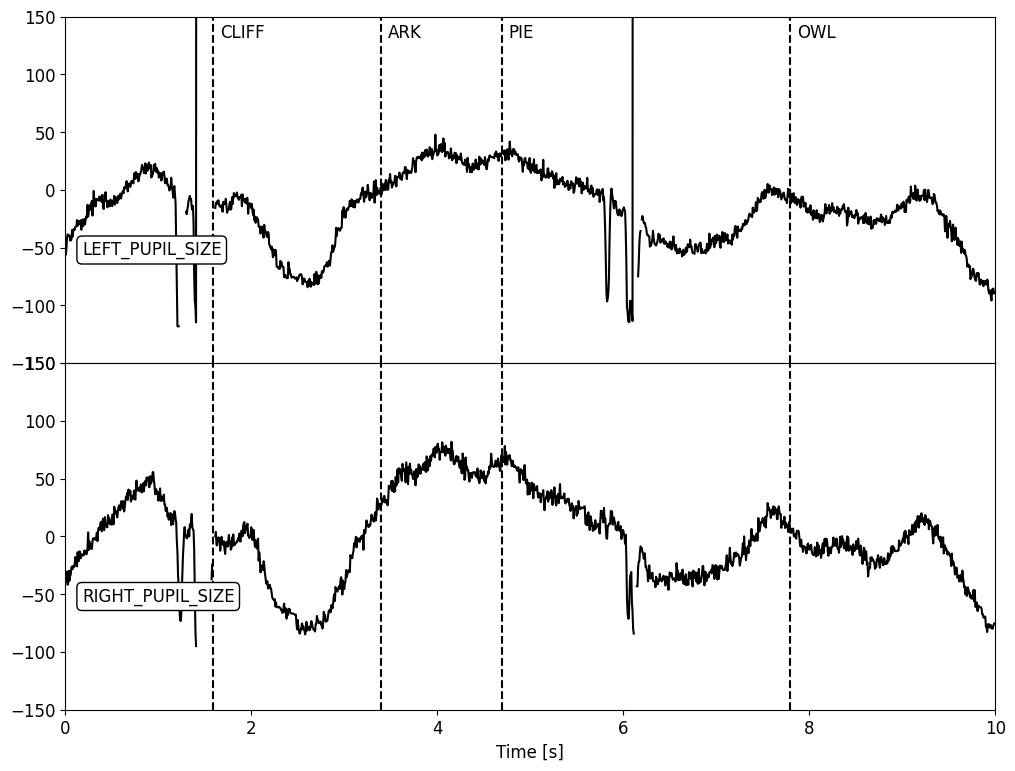

In [121]:
# %% Plot
f, ax_arr = plt.subplots(len(channels),
                         gridspec_kw={'hspace': 0.0}, sharex=True,
                         figsize=(12, 9))

for ax, ch, ch_data in zip(ax_arr, channels, data):
    
    detrended_data = ch_data - np.nanmean(ch_data)
    
    # Pupil size channels
    if 'PUPIL' in ch:
        detrended_data *= np.pi
        detrended_data = detrended_data / 3000000
        
    # iEEG channels
    if 'PUPIL' not in ch and 'MIC' not in ch:
        detrended_data = detrended_data / 1000
    
    fs = [x for x in bi if x['name'] == ch][0]['fsamp'][0]
    unit = [x for x in bi if x['name'] == ch][0]['unit'][0]
    
    plt.sca(ax)
    
    x = np.arange(0, win_size, 1/fs)
    plt.plot(x, detrended_data, label=ch, color='k')
    
    ax.annotate(ch, xy=(12, 88), xycoords='axes points',
                size=12,
                ha='left', va='top',
                bbox=dict(boxstyle='round', fc='w'))
    
    # Pupil size channels
    if 'PUPIL' in ch:
        ax.set_ylim((-0.15*10e2, 0.15*10e2))
        
    # iEEG channels
    if 'PUPIL' not in ch and 'MIC' not in ch:
        ax.set_ylim((-7.5, 7.5))
            
    # Take care of records
    y_lim = ax.get_ylim()
    for rec in records_in_win:
        # Determine the sample
        
        samp = (rec['time'] - start_time)/1e6
        plt.plot([samp, samp], y_lim, 'k--')
        
        if ch == channels[0]:
            ax.annotate(rec['text'], xy=(samp, y_lim[1]),
                        size=12, va='top',
                        xytext=(5, -5), textcoords='offset points')
        
    ax.set_ylim(y_lim)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.xlim((0, win_size))
plt.xlabel('Time [s]', fontsize=12)